In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

### import scoring function

In [2]:
# Code from Lars Grönberg
def binaryScore(y: pd.Series, y_pred: pd.Series, normalize :bool = False) -> float:
    """Calculates the score according to the DMC22 evalution rules for a binary prediction and response

    Args:
        y (pd.Series): true y_
        y_pred (pd.Series): predicted y
        normalize (bool): normalizes the score to a value in [0,1]. Defaults to false.

    Raises:
        ValueError: If number of unique classes in y or y_pred is different from 2

    Returns:
        int: Score according to the DMC22 evaluation if normalize is false.
        float: Score according to the DMC22 evaluation if normalize is true.
    
    Examples:
        >>> truey = pd.Series([0,1,0,1])
        >>> predy = pd.Series([1,0,1,1])
        >>> binaryScore(truey,predy)
        1.5

        >>> truey = pd.Series([0,1,0,1])
        >>> predy = pd.Series([1,0,1,1])
        >>> binaryScore(truey,predy, normalize=True)
        0.3

        >>> truey = pd.Series([1,1,0,1])
        >>> predy = pd.Series([1,1,0,1])
        >>> binaryScore(truey,predy)
        5.5

        >>> truey = pd.Series([1,1,0,1])
        >>> predy = pd.Series([1,1,0,1])
        >>> binaryScore(truey,predy,normalize=True)
        1  
    """
    if (y.astype(int).apply(lambda x: x in [0,1]).all() == False) or (y_pred.astype(int).apply(lambda x: x in [0,1]).all() == False) :
        raise ValueError('y and y_pred are only allowed to contain the elements 0 or 1')

    rightPrediction = np.abs(y-y_pred) == 0
    index0 = (y==0)
    score = np.sum((rightPrediction&index0)*1 + (rightPrediction & ~index0)*1.5)

    if normalize == True:
        maxScore =  np.sum(index0*1 + ~index0*1.5)
        return(score/maxScore)
    else:
        return(score)

In [3]:
binary_train = pd.read_csv('binary_train_70_backgroundTrainTestsplit.csv')
binary_test = pd.read_csv('binary_test_30_backgroundTrainTestsplit.csv')

# I. Splitting train_set and test_set into X_train, y_train, X_test, y_test

In [4]:
X_train = binary_train.drop(columns=['item_bought_next_28_days'])
y_train = binary_train['item_bought_next_28_days']

X_test = binary_test.drop(columns = ['item_bought_next_28_days'])
y_test = binary_test['item_bought_next_28_days']

In [5]:
X_train

,userID,itemID
0,1199,637
1,21557,3520
2,23387,1633
3,32069,29311
4,30359,11124
...,...,...
64238,40754,7997
64239,37518,18630
64240,27676,3997
64241,42405,28532


In [6]:
X_test

,userID,itemID
0,16831,32528
1,25813,12911
2,21519,16041
3,21214,6478
4,20386,19932
...,...,...
27529,2176,9773
27530,20041,19824
27531,39920,18714
27532,5127,1299


# II. Merging X_train, X_test with features

In [7]:
features = pd.read_csv('3_IU_FEAT_Average_Day.csv', index_col = 0).drop(columns=['first_date_bought', 'last_date_bought'])
features

,userID,itemID,average_cycle_days,first_day_delta_bought,last_day_delta_bought
0,0,1505,0.0,93,93
1,0,6446,0.0,194,194
2,0,9325,0.0,173,173
3,0,12468,0.0,64,64
4,0,12505,0.0,79,79
...,...,...,...,...,...
919701,46137,2667,0.0,109,109
919702,46137,20209,0.0,69,69
919703,46137,28343,0.0,69,69
919704,46137,28900,0.0,69,69


In [8]:
X_train_feat = X_train.merge(features, how = 'left', on = ['userID', 'itemID'])
X_test_feat = X_test.merge(features, how = 'left', on = ['userID', 'itemID'])
X_train_feat

,userID,itemID,average_cycle_days,first_day_delta_bought,last_day_delta_bought
0,1199,637,126.0,14,140
1,21557,3520,83.0,72,155
2,23387,1633,124.0,31,155
3,32069,29311,28.0,135,191
4,30359,11124,10.0,119,129
...,...,...,...,...,...
64238,40754,7997,31.0,52,114
64239,37518,18630,65.5,80,211
64240,27676,3997,127.0,77,204
64241,42405,28532,115.0,34,149


In [9]:
X_test_feat

,userID,itemID,average_cycle_days,first_day_delta_bought,last_day_delta_bought
0,16831,32528,64.00,129,193
1,25813,12911,94.00,47,141
2,21519,16041,26.00,108,134
3,21214,6478,84.00,16,100
4,20386,19932,34.00,26,94
...,...,...,...,...,...
27529,2176,9773,42.00,138,180
27530,20041,19824,53.33,25,185
27531,39920,18714,159.00,23,182
27532,5127,1299,47.50,118,213


# III. Training Models

## 1. Random Forest Classification Model

### Training the Random Forest Classification model on the Training set

In [10]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion ='entropy', random_state = 0)
classifier.fit(X_train_feat, y_train)


RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

### Predicting the test set result

In [11]:
y_pred = classifier.predict(X_test_feat)

### Making confusion matrix and evaluating model

In [12]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(cm)
ac = accuracy_score(y_test, y_pred)
print(f"Accuracy score: {ac}")

preci = precision_score(y_test, y_pred, average = None)
print(f"Precision score: {preci}")

recall = recall_score(y_test, y_pred, average = None)
print(f"Recall score: {recall}")

f1_sc = f1_score(y_test, y_pred, average = None)
print(f"f1 score: {f1_sc}")

Confusion matrix:
[[21773   846]
 [ 4225   690]]
Accuracy score: 0.815827703929687
Precision score: [0.8374875  0.44921875]
Recall score: [0.96259782 0.14038657]
f1 score: [0.89569492 0.21392032]


### Applying binaryScore() function to calculate the score of the model
- if y_true = 1 and y_pred = 1  --> getting 1.5 score
- if y_true = 0 and y_pred = 0 --> getting 1 score
- Otherwise 0 score
--> In general, the final score tells us how many score has our model obtained with considering that the value of prediction 1_classifier correctly is higher than that of 0_classifier

In [13]:
score = binaryScore(y_test, pd.Series(y_pred), normalize= False)
score

22808.0

# III. Comparison the predictions which are predicted by model and by using statistics

### 1. Combining y_test and y_pred into a dataframe dataset

In [14]:
dataset = X_test_feat.copy()
dataset['actual_classifier'] = y_test
dataset['model_prediction'] = y_pred
dataset

,userID,itemID,average_cycle_days,first_day_delta_bought,last_day_delta_bought,actual_classifier,model_prediction
0,16831,32528,64.00,129,193,0.0,0.0
1,25813,12911,94.00,47,141,0.0,1.0
2,21519,16041,26.00,108,134,0.0,0.0
3,21214,6478,84.00,16,100,0.0,0.0
4,20386,19932,34.00,26,94,1.0,0.0
...,...,...,...,...,...,...,...
27529,2176,9773,42.00,138,180,0.0,0.0
27530,20041,19824,53.33,25,185,0.0,1.0
27531,39920,18714,159.00,23,182,0.0,0.0
27532,5127,1299,47.50,118,213,1.0,0.0


### 2. Using average_cycle_days and last_day_bought to predict the result of dataset

#### a. calculating the predict_day_delta_bought: 
- predict_day_delta_bought = average_cycle_days + last_day_delta_bought

In [15]:
# calculating column predict_day_delta_bought for all rows
dataset['predict_day_delta_bought'] = dataset.apply(lambda row: row['average_cycle_days'] + row['last_day_delta_bought'], axis=1)
dataset

,userID,itemID,average_cycle_days,first_day_delta_bought,last_day_delta_bought,actual_classifier,model_prediction,predict_day_delta_bought
0,16831,32528,64.00,129,193,0.0,0.0,257.00
1,25813,12911,94.00,47,141,0.0,1.0,235.00
2,21519,16041,26.00,108,134,0.0,0.0,160.00
3,21214,6478,84.00,16,100,0.0,0.0,184.00
4,20386,19932,34.00,26,94,1.0,0.0,128.00
...,...,...,...,...,...,...,...,...
27529,2176,9773,42.00,138,180,0.0,0.0,222.00
27530,20041,19824,53.33,25,185,0.0,1.0,238.33
27531,39920,18714,159.00,23,182,0.0,0.0,341.00
27532,5127,1299,47.50,118,213,1.0,0.0,260.50


#### b. Predicting the result based on predict_day_delta_bought
- If 218 (from 04.01.2021) <= predict_day_delta_bought <= 245 (31.1.2021)  : classifier = 1.0
- else: classifier = 0.0


In [16]:
dataset['statistic_prediction'] = dataset.apply(lambda row: 1.0 if (row['predict_day_delta_bought'] >= 218 and row['predict_day_delta_bought'] <= 245) else 0.0, axis=1)
dataset

,userID,itemID,average_cycle_days,first_day_delta_bought,last_day_delta_bought,actual_classifier,model_prediction,predict_day_delta_bought,statistic_prediction
0,16831,32528,64.00,129,193,0.0,0.0,257.00,0.0
1,25813,12911,94.00,47,141,0.0,1.0,235.00,1.0
2,21519,16041,26.00,108,134,0.0,0.0,160.00,0.0
3,21214,6478,84.00,16,100,0.0,0.0,184.00,0.0
4,20386,19932,34.00,26,94,1.0,0.0,128.00,0.0
...,...,...,...,...,...,...,...,...,...
27529,2176,9773,42.00,138,180,0.0,0.0,222.00,1.0
27530,20041,19824,53.33,25,185,0.0,1.0,238.33,1.0
27531,39920,18714,159.00,23,182,0.0,0.0,341.00,0.0
27532,5127,1299,47.50,118,213,1.0,0.0,260.50,0.0


### 3. Combining results of two different methods and analyzing the results

In [17]:
final_dataset = dataset.drop(columns = ['predict_day_delta_bought'])
final_dataset

,userID,itemID,average_cycle_days,first_day_delta_bought,last_day_delta_bought,actual_classifier,model_prediction,statistic_prediction
0,16831,32528,64.00,129,193,0.0,0.0,0.0
1,25813,12911,94.00,47,141,0.0,1.0,1.0
2,21519,16041,26.00,108,134,0.0,0.0,0.0
3,21214,6478,84.00,16,100,0.0,0.0,0.0
4,20386,19932,34.00,26,94,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
27529,2176,9773,42.00,138,180,0.0,0.0,1.0
27530,20041,19824,53.33,25,185,0.0,1.0,1.0
27531,39920,18714,159.00,23,182,0.0,0.0,0.0
27532,5127,1299,47.50,118,213,1.0,0.0,0.0


In [18]:
actual_classifier_0 = len(final_dataset[final_dataset.actual_classifier == 0.0])
actual_classifier_1 = len(final_dataset[final_dataset.actual_classifier == 1.0])

model_predict_0 = len(final_dataset[final_dataset.model_prediction == 0.0])
model_predict_1 = len(final_dataset[final_dataset.model_prediction == 1.0])

statistic_predict_0 = len(final_dataset[final_dataset.statistic_prediction == 0.0])
statistic_predict_1 = len(final_dataset[final_dataset.statistic_prediction == 1.0])


#### Making confusion matrix and calculating accuracy score of model based on statistics

In [19]:
cm_stat = confusion_matrix(final_dataset['actual_classifier'], final_dataset['statistic_prediction'])
print("Confusion matrix:")
print(cm_stat)
ac_stat = accuracy_score(final_dataset['actual_classifier'], final_dataset['statistic_prediction'])
print(f"Accuracy score: {ac_stat}")

preci_stat = precision_score(final_dataset['actual_classifier'], final_dataset['statistic_prediction'], average = None)
print(f"Precision score: {preci_stat}")

recall_stat = recall_score(final_dataset['actual_classifier'], final_dataset['statistic_prediction'], average = None)
print(f"Recall score: {recall_stat}")

f1_sc_stat = f1_score(final_dataset['actual_classifier'], final_dataset['statistic_prediction'], average = None)
print(f"f1 score: {f1_sc_stat}")


Confusion matrix:
[[19149  3470]
 [ 3376  1539]]
Accuracy score: 0.751361952495097
Precision score: [0.85012209 0.30724696]
Recall score: [0.84658915 0.31312309]
f1 score: [0.84835194 0.31015719]


#### Applying binaryScore() function to calculate the score of the model

In [22]:
score_stat = binaryScore(y_test, final_dataset['statistic_prediction'], normalize= False)
score_stat

21457.5

### 4. Comparing scores of two models

In [23]:
num_model = [cm, ac, score, preci, recall, f1_sc]
num_statistic = [cm_stat, ac_stat, score_stat, preci_stat, recall_stat, f1_sc_stat]

comparison_scores = pd.DataFrame([num_model, num_statistic], 
                                 columns = ['confusion_matrix', 'accuracy','score', 'precision', 'recall', 'f1_score'],
                                index = ['model_prediction','statistics_prediction'])
comparison_scores


,confusion_matrix,accuracy,score,precision,recall,f1_score
model_prediction,"[[21773, 846], [4225, 690]]",0.815828,22808.0,"[0.8374874990383876, 0.44921875]","[0.9625978159954021, 0.14038657171922686]","[0.8956949215295061, 0.21392032243063092]"
statistics_prediction,"[[19149, 3470], [3376, 1539]]",0.751362,21457.5,"[0.8501220865704773, 0.30724695548013575]","[0.8465891507140015, 0.3131230925737538]","[0.8483519404572036, 0.31015719467956465]"


- The Model based on statistis give us the result that is less correct than that of random forest model

### 5. Visualizing

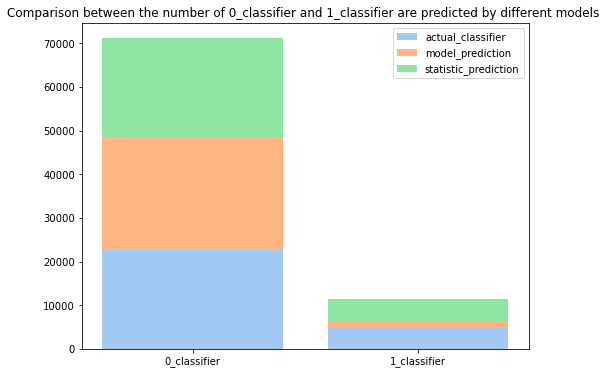

In [25]:
sns.set_palette('pastel')
plt.figure(figsize = (8, 6))
#ax = plt.subplot()
#ax.set_xticks([0, 1])
x = [0, 1]
actual_classifier = [actual_classifier_0, actual_classifier_1]
model_predict = [model_predict_0, model_predict_1]
am = [actual_classifier_0 + model_predict_0, actual_classifier_1 + model_predict_1]
statistic_predict = [statistic_predict_0, statistic_predict_1]

plt.bar(x, actual_classifier)

plt.bar(x, model_predict, bottom=actual_classifier)

plt.bar(x, statistic_predict, bottom = am)

plt.xticks(x, ['0_classifier', '1_classifier'])
plt.legend(['actual_classifier','model_prediction', 'statistic_prediction'])
plt.title('Comparison between the number of 0_classifier and 1_classifier are predicted by different models ')

plt.show()

- There are a huge difference between results which are predicted by random forest model and by using statistic method. 
